<a href="https://colab.research.google.com/github/AbiaAlvesReis/AMMS-Projeto-IA-2022-01/blob/main/AMMS_TensorFlowlotteryvideoP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SEGUNDA PARTE**

In [164]:
import os
import datetime

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib as mpl
import missingno as msno
import math
import IPython
import IPython.display
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [165]:
megadf2 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/dados testes /loteriascaixa_at.xlsx', parse_dates=True, index_col=1)

In [166]:
# Número de linhas e de colunas
megadf2.shape


(2485, 7)

In [167]:
megadf2.head()

,lottery,ball_01,ball_02,ball_03,ball_04,ball_05,ball_06
date,,,,,,,
1996-03-11,1.0,41.0,5.0,4.0,52.0,30.0,33.0
1996-03-18,2.0,9.0,39.0,37.0,49.0,43.0,41.0
1996-03-25,3.0,36.0,30.0,10.0,11.0,29.0,47.0
1996-04-01,4.0,6.0,59.0,42.0,27.0,1.0,5.0
1996-04-08,5.0,1.0,19.0,46.0,6.0,16.0,2.0


In [168]:
megadf2 = megadf2.sort_values(by=['date'], ascending=False)


In [169]:
megadf2.drop('lottery', inplace=True, axis=1)


In [170]:
megadf2.head()

,ball_01,ball_02,ball_03,ball_04,ball_05,ball_06
date,,,,,,
2022-05-28,60.0,12.0,38.0,47.0,5.0,32.0
2022-05-25,59.0,36.0,41.0,54.0,14.0,11.0
2022-05-21,54.0,49.0,34.0,38.0,40.0,20.0
2022-05-18,32.0,1.0,57.0,44.0,35.0,45.0
2022-05-14,1.0,37.0,36.0,21.0,8.0,27.0


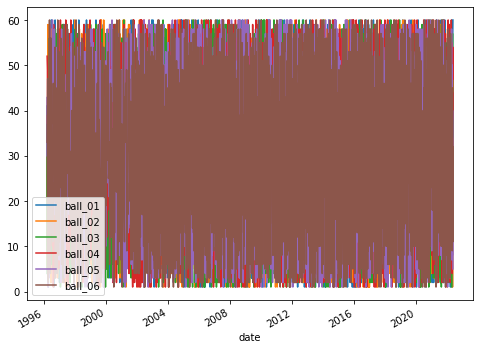

In [171]:
megadf2.plot()

In [172]:
df = megadf2
n= len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7): int (n*0.9)]
test_df = df[int(n*0.9):]
num_dfs = df.shape[1]



Normalização dos tados - Subtrair a média e dividir pelo desvio padrão de cada recurso, usando média simples

In [173]:
train_mean = train_df.mean()
train_std = train_df.std()
train_df_norm = (train_df - train_mean) / train_std
val_df_norm = (val_df - train_mean) / train_std
test_df_norm = (test_df - train_mean) / train_std



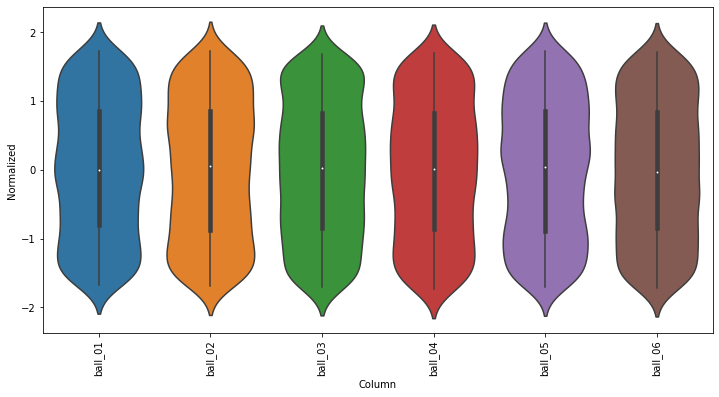

In [174]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [176]:
'''class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df = train_df_norm, val_df = val_df_norm, test_df = test_df_norm, label_columns=None):
      
      #store the raw data
        self.train_df = train_df_norm
        self.val_df = val_df_norm
        self.test_df = test_df_norm

        self.label_column_indices = {}

        #work out the label column indices
        self.label_columns = label_columns
        if label_columns is not None:
           self.label_column_indices = {name: i for i, name in enumerate(label_columns)}
           self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        #work out window paramenters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = self.input_width + self.shift

        self.input_slice = slice(0,input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.label_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.label_slice]




    def __repr__(self):
        return '\n'.join((
            f'total window size: {self.total_window_size}',
            f'input indices: {self.input_indices}',
            f'label indices: {self.label_indices}',
            f'label column name(s): {self.label_columns}',
            f'label colunn indices: {self.label_column_indices}'))'''

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df_norm, val_df=val_df_norm, test_df=test_df_norm,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df_norm
    self.val_df = val_df_norm
    self.test_df = test_df_norm
    self.label_columns_indices = {}

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])   
    


In [177]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.calibacks.kcarlystopping(monitor = 'val_loss', patiece = patience, mode = 'mim')
       
  model.compile(loss = tf.keras.losses.MeanSquaredError(), 
                metrics = [tf.keras.metrics.MeanAbsoluteError()])
       
  history = model.fit(window.train, epochs = MAX_EPOCHS, 
                      validation_megadf2 = window.val,
                      callbacks = [early_stopping])
  return history

In [178]:
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1, label_columns=['date'])
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['date']

In [179]:
single_step_window = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['date'])
single_step_window

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['date']

In [180]:
'''def make_dataset(self, megadf2):
    megadf2  = np.array(megadf2, dtype=np.float32)     
    ds = tf.keras.preprocessing.timesseries_dataset_from_array(
        megadf2 = megadf2,
        targets=None, 
        sequence_lenggth=self.total_window_size,
        shuffle=True,
        batch_size=64,)
    ds = ds.map(self.split_window)
    return ds

WindowGenerator.make_dataset = make_dataset'''

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset




In [181]:

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example







In [182]:
'''def split_window(self, features):
    inputs = features[:, self.input_slice]
    labels = features[:, self.labels_slice]

    if self.label_columns is not None:
        labels = tf.stack((labels[:,:, self.label_column_indices[name]] for name in self.label_columns), axis=1)
        # silicing doean1s preserve static  shape information, ao set the shapes
        ## manualy. thys way the 'tf.mdagadf2.datasets' are earler to inapect

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
WindowGenerator.split_window = split_window'''

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window


In [183]:
'''def plot(self, model = None, max_subplots = 6):
  plot_col = ["ball_01", "ball_02", "ball_03", "ball_04", "ball_05", "ball_06"]
  inputs, labels = self.example
  plt.figure(figsize=(12,8))
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plot_col_index = self.column_indices[plot_col[n]]
    plt.subplot(6,1,n+1)
    plt.ylabel(f'{plot_col[n]}')
    plt.plot(self.input_indices, inputs [n, :, plot_col_index],
             label = "inputs", marker = ".", zorder = -10)
        
    if self.label_columns:
      label_col_index = self.label_column_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue
        
    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', e='#lca07c', s=64)
        
    if model is not None:
      prediction = model (inputs)
      #print ("x.shape, ', self.label_indices.sahpe")
      #print ("y.shape, ', predictions[n].shape")
      plt.scatter(self.label_indices, prediction[n, :, label_col_index],
                  marker='x', edgecolors='k', label='predictions',
                  c='#tt7t0e', s=64)

    if n == 0:
      plt.legend()

  plt.slabel('Time')
  return predictions, labels
WindowGenerator.plot = plot'''

def plot(self, model=None, max_subplots=6):
  plot_col = ["ball_01", "ball_02", "ball_03", "ball_04", "ball_05", "ball_06"]
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n): 
    plot_col_index = self.column_indices[plot_col[n]]   
    plt.subplot(6, 1, n+1)
    plt.ylabel(f'{plot_col[n]}')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time')
  return predictions, labels

WindowGenerator.plot = plot



In [184]:


wide_window = WindowGenerator(input_width=24, label_width=24, shift=1)

In [185]:

single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1)

In [186]:
single_val_performace  = {}
single_performance = {}
val_performance = {}
performace = {}

In [187]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]



TEste

In [188]:

MAX_EPOCHS = 50
def compile_and_fit(model, window, patience=2):
    #early_stopping = tf.keras.calibacks.kcarlystopping(monitor = 'val_loss', patiece = patience, mode = 'mim')  
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
       
    history = model.fit(window.train, epochs=MAX_EPOCHS, 
                          validation_data = window.val,
                           #callbacks = [carly_stoppig]
                          )                            
    return history
   


In [189]:
baseline = Baseline()
history = compile_and_fit(baseline, single_step_window)

Epoch 1/50
55/55 [==============================] - 1s 8ms/step - loss: 2.0153 - mean_absolute_error: 1.1569 - val_loss: 1.9187 - val_mean_absolute_error: 1.1182
Epoch 2/50
55/55 [==============================] - 0s 6ms/step - loss: 2.0153 - mean_absolute_error: 1.1569 - val_loss: 1.9187 - val_mean_absolute_error: 1.1182
Epoch 3/50
55/55 [==============================] - 0s 6ms/step - loss: 2.0153 - mean_absolute_error: 1.1569 - val_loss: 1.9187 - val_mean_absolute_error: 1.1182
Epoch 4/50
55/55 [==============================] - 0s 7ms/step - loss: 2.0153 - mean_absolute_error: 1.1569 - val_loss: 1.9187 - val_mean_absolute_error: 1.1182
Epoch 5/50
55/55 [==============================] - 0s 6ms/step - loss: 2.0153 - mean_absolute_error: 1.1569 - val_loss: 1.9187 - val_mean_absolute_error: 1.1182
Epoch 6/50
55/55 [==============================] - 0s 6ms/step - loss: 2.0153 - mean_absolute_error: 1.1569 - val_loss: 1.9187 - val_mean_absolute_error: 1.1182
Epoch 7/50
55/55 [==========

In [190]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 6)
Output shape: (32, 24, 6)


(<tf.Tensor: shape=(32, 24, 6), dtype=float32, numpy=
 array([[[ 1.6675789 , -1.166065  , -0.8395723 , -0.9811588 ,
          -1.354316  ,  1.3664668 ],
         [-0.635727  ,  0.16670923, -0.72496235,  0.7035814 ,
           1.7221183 , -1.7130536 ],
         [ 0.4583433 , -1.6296386 ,  0.82227206,  0.23882549,
          -0.5997189 ,  1.1921543 ],
         ...,
         [ 0.22801271,  0.92001635, -0.95418227, -0.16783595,
          -1.1221323 , -0.8414912 ],
         [ 0.28559536, -0.06507758,  0.36383224, -1.0392534 ,
          -1.412362  , -0.028033  ],
         [ 1.0341698 ,  0.22465594, -0.3238275 ,  0.6454869 ,
          -1.0060405 , -1.3063245 ]],
 
        [[ 0.343178  , -1.166065  ,  1.6818467 ,  1.2264318 ,
           1.141659  , -0.43476212],
         [ 0.28559536,  0.05081583, -1.527232  , -0.05164697,
           1.3738427 , -0.14424132],
         [ 0.05526477,  1.4415367 ,  1.4526268 ,  1.1102428 ,
           0.56119967, -1.1901162 ],
         ...,
         [ 0.11284742,  

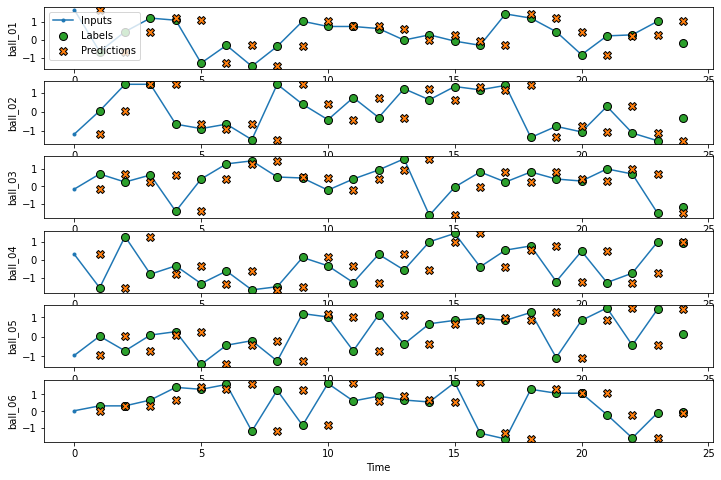

In [191]:
wide_window.plot(baseline)

In [192]:
single_val_performace  = {}
single_performance = {}
val_performance = {}
performace = {}

In [193]:
baseline = Baseline() 
_= compile_and_fit(baseline, single_step_window)

IPython.display.clear_output()
single_val_performace['Baseline'] = baseline.evaluate(single_step_window.val)
single_performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)
val_performance['Baseline'] = single_val_performace['Baseline']
performace['Baseline'] = single_performance['Baseline']



16/16 [==============================] - 0s 3ms/step - loss: 1.9187 - mean_absolute_error: 1.1182


Coloquei apenas para eu entender....

In [194]:
dense_ANN = tf.keras.models.Sequential([
      tf.keras.layers.Dense(units=16, activation = tf.keras.layers.LeakyReLU(alpha= 0.01)),
      tf.keras.layers.Dense(units=6)
])

In [195]:
history = compile_and_fit(dense_ANN, single_step_window)

val_performance['Dense'] = dense_ANN.evaluate(single_step_window.val)
performace['Dense'] = dense_ANN.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
55/55 [==============================] - 1s 10ms/step - loss: 1.3960 - mean_absolute_error: 0.9795 - val_loss: 1.2272 - val_mean_absolute_error: 0.9284
Epoch 2/50
55/55 [==============================] - 0s 7ms/step - loss: 1.1592 - mean_absolute_error: 0.9115 - val_loss: 1.0918 - val_mean_absolute_error: 0.8910
Epoch 3/50
55/55 [==============================] - 1s 9ms/step - loss: 1.0691 - mean_absolute_error: 0.8850 - val_loss: 1.0405 - val_mean_absolute_error: 0.8763
Epoch 4/50
55/55 [==============================] - 0s 7ms/step - loss: 1.0352 - mean_absolute_error: 0.8748 - val_loss: 1.0218 - val_mean_absolute_error: 0.8701
Epoch 5/50
55/55 [==============================] - 0s 6ms/step - loss: 1.0212 - mean_absolute_error: 0.8703 - val_loss: 1.0129 - val_mean_absolute_error: 0.8671
Epoch 6/50
55/55 [==============================] - 0s 7ms/step - loss: 1.0139 - mean_absolute_error: 0.8680 - val_loss: 1.0079 - val_mean_absolute_error: 0.8653
Epoch 7/50
55/55 [=========

In [196]:
# 
history = history.history

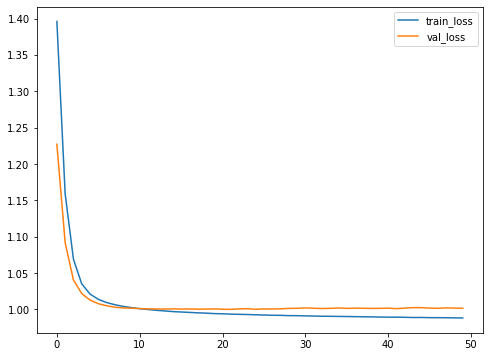

In [197]:
# 
plt.plot(history["loss"], label = "train_loss")
plt.plot(history["val_loss"], label = "val_loss")
plt.legend()
plt.show()

In [198]:
# 
single_step_window.total_window_size

2

In [199]:
#stack alices (total inputs and labels), tehe length of the total window:
example_window = tf.stack([np.array(train_df[:single_step_window.total_window_size]),
                           np.array(train_df[2:2+single_step_window.total_window_size]),
                           np.array(train_df[4:4+single_step_window.total_window_size]),
                           np.array(train_df[6:6+single_step_window.total_window_size])])

In [200]:
example_window.shape

TensorShape([4, 2, 6])

In [201]:
example_inputs, example_labels = single_step_window.split_window(example_window)

In [202]:
single_step_window.other = example_inputs, example_labels

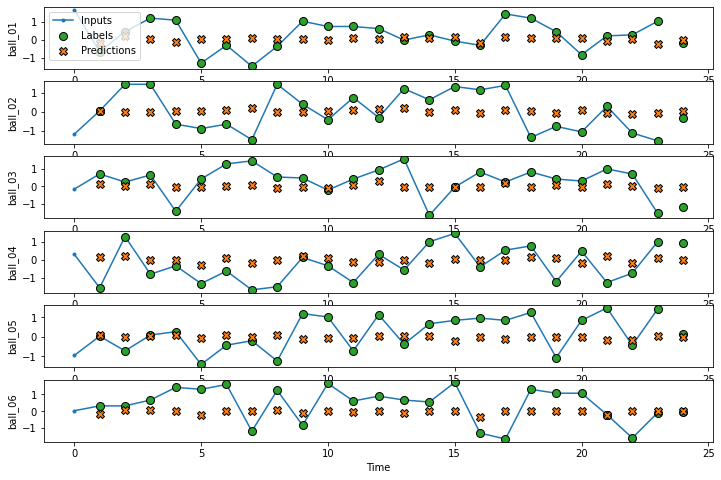

In [203]:
predictions = wide_window.plot(dense_ANN)

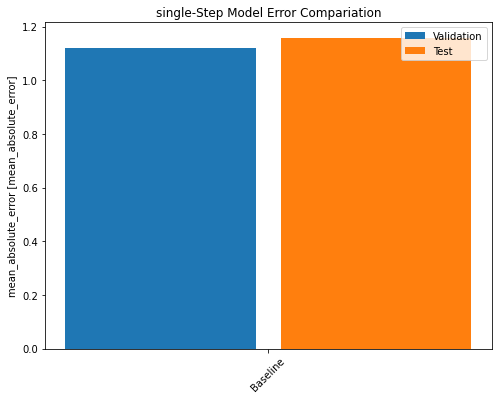

In [205]:
x = np.arange(len(single_val_performace))
width = 0.3
metric_name = "mean_absolute_error"
metric_index = dense_ANN.metrics_names.index("mean_absolute_error")
val_nae = {v[metric_index] for v in single_val_performace.values()}
test_nae = {v[metric_index] for v in single_performance.values()}


plt.title('single-Step Model Error Compariation')
plt.ylabel('mean_absolute_error [mean_absolute_error]')
plt.bar(x - 0.17, val_nae, width, label='Validation')
plt.bar(x + 0.17, test_nae, width, label='Test')
plt.xticks(ticks=x,labels=single_performance.keys(),rotation=45)
_ = plt.legend()


In [206]:
inputs = df[['ball_01','ball_02','ball_03','ball_04','ball_05','ball_06']].iloc(1)

Normaliza os dados novamente



In [207]:
megadf2_mean = df.mean()
megadf2_std = df.std()

inputs_norm = (df - megadf2_mean) / megadf2_std

In [208]:
new_arr = np.expand_dims(inputs_norm, axis=0)

In [209]:
pred_norm = dense_ANN.predict (new_arr).astype(int)
pred_norm

array([[[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]])

Next deawing predicion

In [210]:
np.floor(pred_norm).astype(int)

array([[[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]])